# PageRank

Выолнил: Ануфриев Валентин

In [1]:
%pip install networkx
%pip install python-graphblas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 3.7 MB/s eta 0:00:00


In [2]:
import graphblas as gb
import networkx as nx
from graphblas import Matrix, Vector
from graphblas import unary, binary, monoid, semiring, dtypes

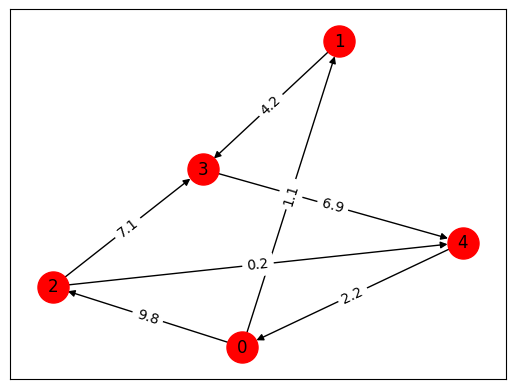

In [3]:
A = Matrix.from_coo(
    [0, 0, 1, 2, 2, 3, 4],
    [1, 2, 3, 3, 4, 4, 0],
    [1.1, 9.8, 4.2, 7.1, 0.2, 6.9, 2.2],
)
gb.viz.draw(A)

# Задача 1


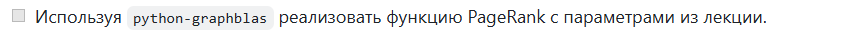

In [4]:
def pagerank_3f(A, d_out, damping=0.85, itermax=100, tol=1e-4):
    """
    Returns (result as Vector, iters as int)
    """
    n = A.nrows
    teleport = (1 - damping) / n
    rdiff = 1  # first iteration is always done

    # r = 1 / n
    t = Vector(dtypes.FP32, n)
    r = Vector(dtypes.FP32, n)
    w = Vector(dtypes.FP32, n)
    r[:] << 1.0 / n



    d = d_out.dup(dtype="FP32")
    d(accum=binary.truediv)[:] << damping

    # --------------------------------------------------------------------------
    # pagerank iterations
    # --------------------------------------------------------------------------
    for i in range(itermax):
        if rdiff <= tol:
            break

        # swap t and r ; now t is the old score
        r, t = t, r

        # w = t ./ d
        w << t.ewise_mult(d, binary.truediv)

        # r = teleport
        r[:] << teleport

        # r += A'*w
        r(binary.plus) << A.T.mxv(w, semiring.plus_second)

        # t -= r
        t(binary.minus)[:] << r

        # t = abs (t)
        t << t.apply(unary.abs)

        # rdiff = sum (t)
        rdiff = t.reduce(monoid.plus).value

    return r, i

In [5]:
A << A.apply(unary.one)
A

"M_0"      nvals  nrows  ncols  dtype         format
gb.Matrix      7      5      5   FP64  bitmapr (iso)
----------------------------------------------------
     0    1    2    3    4
0       1.0  1.0          
1                 1.0     
2                 1.0  1.0
3                      1.0
4  1.0

In [6]:
d_out = A.reduce_rowwise(monoid.plus).new()
d_out

"v_0"      nvals  size  dtype  format
gb.Vector      5     5   FP64    full
-------------------------------------
index    0    1    2    3    4
value  2.0  1.0  2.0  1.0  1.0

In [7]:
result, iters = pagerank_3f(A, d_out)
print(result)
iters

"v_1"      nvals  size  dtype  format
gb.Vector      5     5   FP32    full
-------------------------------------
index         0         1         2         3         4
value  0.254212  0.138031  0.138031  0.205973  0.263752


37

In [8]:
#Сравнение с networkx
g = gb.io.to_networkx(A)
g.edges()

OutEdgeView([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4), (4, 0)])

In [9]:
nx.pagerank(g, tol=1e-4)

{0: 0.2542370526098617,
 1: 0.13807850431853438,
 2: 0.13807850431853438,
 3: 0.2059371902920227,
 4: 0.2636687484610469}

# Задача 2

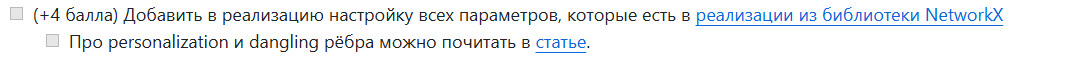

personalization — позволяет указать индивидуальные веса (важность) для каждого узла при расчёте PageRank.

nstart — задаёт начальные значения вероятностей для узлов, с которых начинается итерационный процесс вычисления PageRank.

dangling — определяет, как перераспределяются веса от висячих узлов (тех, у которых нет исходящих рёбер).

In [10]:
def pagerank_nx(A, alpha=0.85, personalization=None, max_iter=100, tol=1e-4,
                nstart=None, weight='weight', dangling=None):
    n = A.nrows
    teleport = (1 - alpha) / n
    rdiff = 1


    if personalization is None:  # Если не заданы то равномерное
      personalization = {i: 1.0 for i in range(n)}
    else:
      total_weight = sum(personalization.values())
      personalization = {i: value / total_weight for i, value in personalization.items()} # Нормализуем
    p = Vector.from_dict(personalization, size=n, dtype=dtypes.FP32) # Создаём вектор


    # Обработка "dangling" узлов (узлы без исходящих рёбер)
    if dangling is None: # Если не заданы то равномерное
        dangling_weights = {i: 1.0 / n for i in range(n)}
    else:  # Если  заданы то их значения
        dangling_weights = {i: dangling.get(i, 0) for i in range(n)}
    dangle_sum = sum(dangling_weights.values()) # Считаем сумму весов
    dangling_vec = Vector.from_dict(dangling_weights, size=n, dtype=dtypes.FP32) # Создаём вектор
    dangling_vec(binary.times)[:] = 1.0 / dangle_sum # Нормализуем

    # Инициализация вектора PageRank
    r = Vector(dtypes.FP32, n)
    if nstart is None: # Если не заданы то равномерное
        r[:] = 1.0 / n
    else:
        r.update(Vector.from_dict(nstart, size=n, dtype=dtypes.FP32))  # Используем заданные начальные значения
    t = Vector(dtypes.FP32, n)
    w = Vector(dtypes.FP32, n)

    # Вектор выходной степени
    d_out = A.reduce_rowwise(monoid.plus).new(dtype=dtypes.FP32)
    d = d_out.dup()
    d(binary.times)[:] = alpha  # Масштабируем выходную степень на alpha

    for i in range(max_iter):
        if rdiff <= tol:  # Проверяем условие остановки
            break

        # Меняем местами t и r; теперь t - это старая оценка
        r, t = t, r

        # w = t ./ d
        w(binary.truediv)[:] = t.ewise_mult(d, binary.truediv)

        # r = teleport * p + alpha * (A' * w + dangling_vec)
        r[:] = teleport * p
        r(binary.plus)[:] = A.T.mxv(w, semiring.plus_times)
        r(binary.plus)[:] = alpha * (r + dangling_vec)

        # t -= r
        t(binary.minus)[:] = r

        # t = abs(t)
        t.apply(unary.abs)

        # rdiff = sum(t)
        rdiff = t.reduce(monoid.plus).value

    return r, i


In [11]:
from graphblas.io import mmread
import time
import sys
import random

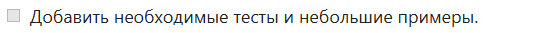

## Проверка 1

In [ ]:
M1 = mmread('/content/crok.mtx')
M1

"M_12"     nvals  nrows  ncols  dtype     format
gb.Matrix  60760  10240  10240   FP64  csr (iso)
------------------------------------------------
      0     1     2     3     4     5     6     7     8     9      ... 10230  \
0                                                                  ...         
1                                                                  ...         
2                                                                  ...         
3                                                                  ...         
4                                                                  ...         
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
10235                                                              ...         
10236                                                              ...         
10237                                                              ...         
10238                                                              ...         
10239                                                              ...         

      10231 10232 10233 10234 10235 10236 10237 10238 10239  
0                                                            
1                                                            
2                                                            
3                                                            
4                                                            
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
10235   1.0               1.0                                
10236                                       1.0   1.0   1.0  
10237                     1.0         1.0                    
10238                                 1.0                    
10239                                 1.0

In [ ]:
result_nx, iters_nx = pagerank_nx(M1,
                                 #personalization = {0: 0.4, 1: 0.4, 2: 0.2} ,
                                  alpha=0.85,
                                  max_iter=100,
                                  tol=1e-4,
                                  #nstart = {0: 0.5, 1: 0.5, 2: 0.5} ,
                                  #dangling = {0: 0.5, 1: 0.3, 2: 0.2}
                                  )
result_nx


"v_131888"  nvals   size  dtype  format
gb.Vector   10240  10240   FP32    full
---------------------------------------
index     0         1         2         3         4         5         6      \
value  0.000203  0.000216  0.000211  0.000203  0.000301  0.000515  0.000301   

index     7         8         9      ...     10230     10231     10232  \
value  0.000216  0.000345  0.000216  ...  0.000193  0.000349  0.000197   

index     10233     10234     10235     10236     10237     10238     10239  
value  0.000197  0.000304  0.000202  0.000358  0.000211  0.000197  0.000197

In [ ]:
result_nx_networkx = nx.pagerank(g_1, alpha=0.85, max_iter=100, tol=1e-4)


## Проверка 2

In [ ]:
M2 = mmread('/content/df.mtx')
M2

"M_15"     nvals  nrows  ncols  dtype     format
gb.Matrix  30186   2851   2851   FP64  csr (iso)
------------------------------------------------
     0    1    2    3    4    5    6    7    8    9     ... 2841 2842 2843  \
0          1.0  1.0  1.0  1.0  1.0  1.0                 ...                  
1     1.0       1.0  1.0  1.0  1.0       1.0            ...                  
2     1.0  1.0       1.0  1.0       1.0  1.0  1.0  1.0  ...                  
3     1.0  1.0  1.0            1.0  1.0  1.0  1.0  1.0  ...                  
4     1.0  1.0  1.0            1.0  1.0  1.0            ...                  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2846                                                    ...                  
2847                                                    ...                  
2848                                                    ...                  
2849                                                    ...                  
2850                                                    ...                  

     2844 2845 2846 2847 2848 2849 2850  
0                                        
1                                        
2                                        
3                                        
4                                        
...   ...  ...  ...  ...  ...  ...  ...  
2846       1.0       1.0                 
2847            1.0       1.0            
2848                 1.0       1.0       
2849                      1.0       1.0  
2850                           1.0

In [ ]:
result_nx, iters_nx = pagerank_nx(M2,
                                 #personalization = {0: 0.4, 1: 0.4, 2: 0.2} ,
                                  alpha=0.85,
                                  max_iter=100,
                                  tol=1e-4,
                                  #nstart = {0: 0.5, 1: 0.5, 2: 0.5} ,
                                  #dangling = {0: 0.5, 1: 0.3, 2: 0.2}
                                  )
result_nx


"v_350"    nvals  size  dtype  format
gb.Vector   2851  2851   FP32    full
-------------------------------------
index      0         1         2         3         4         5         6     \
value  0.001012  0.001129  0.001129  0.001366  0.001012  0.001129  0.001129   

index      7         8         9     ...      2841      2842      2843  \
value  0.001366  0.001054  0.001263  ...  0.000987  0.000987  0.000987   

index      2844      2845      2846      2847      2848      2849      2850  
value  0.000987  0.000987  0.000987  0.000987  0.000987  0.001146  0.000796

## Проверка 3

In [ ]:
M3 = mmread('/content/G8.mtx')
M3

"M_11"     nvals  nrows  ncols  dtype     format
gb.Matrix  38352    800    800   FP64  csr (iso)
------------------------------------------------
    0   1   2   3   4   5    6    7   8   9    ...  790  791  792 793 794  \
0                                              ...       1.0                
1                            1.0               ...                          
2                                              ...                          
3                                              ...                          
4                                              ...                          
..   ..  ..  ..  ..  ..  ..  ...  ...  ..  ..  ...  ...  ...  ...  ..  ..   
795                                            ...            1.0           
796                                            ...                          
797                                            ...  1.0                     
798                                            ...            1.0           
799                               1.0          ...                          

     795 796  797 798  799  
0                           
1                           
2                           
3                           
4                           
..   ...  ..  ...  ..  ...  
795           1.0           
796                         
797  1.0               1.0  
798                         
799           1.0

In [ ]:
result_nx, iters_nx = pagerank_nx(M3,
                                  #personalization = {0: 0.4, 1: 0.4, 2: 0.2} ,
                                  alpha=0.85,
                                  max_iter=100,
                                  tol=1e-4,
                                  #nstart = {0: 0.5, 1: 0.5, 2: 0.5} ,
                                  #dangling = {0: 0.5, 1: 0.3, 2: 0.2}
                                  )
result_nx


"v_434"    nvals  size  dtype  format
gb.Vector    800   800   FP32    full
-------------------------------------
index       0         1         2         3         4         5         6    \
value  0.003699  0.004377  0.004197  0.005129  0.004316  0.003852  0.004506   

index       7         8         9    ...       790       791       792  \
value  0.003728  0.003985  0.003562  ...  0.004434  0.003539  0.004235   

index       793       794       795       796       797       798       799  
value  0.004413  0.004203  0.004572  0.004196  0.004255  0.004798  0.004669

In [ ]:
nstart = {0: 0.5, 1: 0.5, 2: 0.5}

personalization = {0: 0.4, 1: 0.4, 2: 0.2}

dangling = {0: 0.5, 1: 0.3, 2: 0.2}

# Задача 3

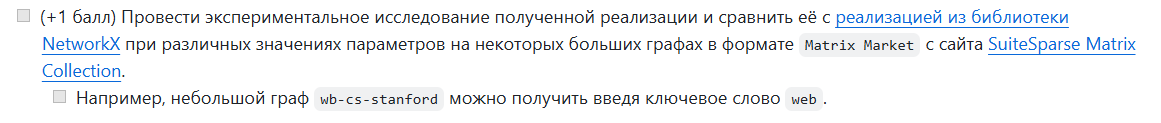

In [ ]:
%%timeit
result_nx_1, iters_nx_1 = pagerank_nx(M1, alpha=0.85, max_iter=100, tol=1e-6)

8.7 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
g_1 = gb.io.to_networkx(M1)
g_2 = gb.io.to_networkx(M2)
g_3 = gb.io.to_networkx(M3)

In [ ]:
%%timeit
nx.pagerank(g_1, alpha=0.85, max_iter=100, tol=1e-6)

89.9 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Графы

### 1

In [ ]:
%%timeit
result_nx_1, iters_nx_1 = pagerank_nx(M1,
                                  personalization = {0: 0.5, 1: 0.4, 2: 0.1} ,
                                  alpha=0.85,
                                  max_iter=100,
                                  tol=1e-4,
                                  nstart = {0: 0.5, 1: 0.5, 2: 0.5} ,
                                  weight=None,
                                  dangling = {0: 0.4, 1: 0.3, 2: 0.3}
                                  )

7.92 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
nx.pagerank(g_1,personalization = {0: 0.5, 1: 0.4, 2: 0.1} ,
                                  alpha=0.85,
                                  max_iter=100,
                                  tol=1e-4,
                                  nstart = {0: 0.5, 1: 0.5, 2: 0.5} ,
                                  weight=None,
                                  dangling = {0: 0.4, 1: 0.3, 2: 0.3}
                                  )


91.8 ms ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 2

In [ ]:
%%timeit
result_nx_2, iters_nx_2 = pagerank_nx(M2,
                                  personalization = {0: 0.5, 1: 0.4, 2: 0.1} ,
                                  alpha=0.85,
                                  max_iter=100,
                                  tol=1e-4,
                                  nstart = {0: 0.5, 1: 0.5, 2: 0.5} ,
                                  weight=None,
                                  dangling = {0: 0.4, 1: 0.3, 2: 0.3}
                                  )

5.92 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
nx.pagerank(g_2,personalization = {0: 0.5, 1: 0.4, 2: 0.1} ,
                                  alpha=0.85,
                                  max_iter=100,
                                  tol=1e-4,
                                  nstart = {0: 0.5, 1: 0.5, 2: 0.5} ,
                                  weight=None,
                                  dangling = {0: 0.4, 1: 0.3, 2: 0.3}
                                  )


34.1 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 3

In [ ]:
%%timeit
result_nx_3, iters_nx_3 = pagerank_nx(M3,
                                  personalization = {0: 0.5, 1: 0.4, 2: 0.1} ,
                                  alpha=0.85,
                                  max_iter=100,
                                  tol=1e-4,
                                  nstart = {0: 0.5, 1: 0.5, 2: 0.5} ,
                                  weight=None,
                                  dangling = {0: 0.4, 1: 0.3, 2: 0.3}
                                  )

4.28 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
nx.pagerank(g_3,
            personalization = {0: 0.5, 1: 0.4, 2: 0.1} ,
                                  alpha=0.85,
                                  max_iter=100,
                                  tol=1e-4,
                                  nstart = {0: 0.5, 1: 0.5, 2: 0.5} ,
                                  weight=None,
                                  dangling = {0: 0.4, 1: 0.3, 2: 0.3}
                                  )


48.8 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Результаты показали, что пользовательская реализация pagerank_nx работает значительно быстрее, чем встроенная функция nx.pagerank.







